## ch18 xgbfir(Feature Interations Reshaped)
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.9</div>
<div style="text-align: right"> Last update: 2023.8.9</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

### 18.1 Feature Interactions


결정트리에서 A feature, X1 does not interact withanother feature, X2, if X2 is not in the path, or if X2 is used the same in each path. Otherwise,there is an interaction, and both features combined to impact the result.

### 18.2 xgbfir

The xgbfir library will allow us to find the top interactions from our data in an XGBoost model.  


In [9]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

사용법은 약간 특이한데 엑셀파일로 저장한다. 그래서 openpyxl을 설치해야한다.   
모델을 만들고 saveXgbFI 함수를 실행한다.  
그러면 여러 시트로 된 엑셀파일을 저장한다.

In [10]:
import xgbfir
xgbfir.saveXgbFI(xgb_def, feature_names=X_train.columns, OutputXlsxFile='fir.xlsx')

첫번째 시트를 살펴보면, 인덱스에 데이터의 모든 피처를 보여주고 있다.   
그리고 컬럼에는 메트릭, 랭크 등을 보여준다.  
인덱스의 순서는 메트릭의 평균 랭킹으로 순서환 된것이다.  
컬럼 정보는 다음과 같다.  

- Gain: Total gain of each feature or feature interaction
- FScore: Amount of possible splits taken on a feature or feature Interaction
- wFScore: Amount of possible splits taken on a feature or feature interaction weighted by
the probability of the splits to take place
- Average wFScore: wFScore divided by FScore
- Average Gain: Gain divided by FScore
- Expected Gain: Total gain of each feature or feature interaction weighted by the
probability of the gain

In [11]:
fir = pd.read_excel('fir.xlsx') 

In [12]:
fir

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,years_exp,597.020128,627,88.208192,0.140683,0.952185,87.892397,1,2,3,12,6,3,4.500000,45.108453,3.706539
1,compensation,518.545899,702,123.048351,0.175283,0.738669,59.698727,2,1,1,8,12,5,4.833333,47.478632,3.719373
2,r,517.795525,84,34.214997,0.407321,6.164232,479.394350,3,8,5,2,1,1,3.333333,44.630952,2.607143
3,age,337.675898,493,118.716047,0.240803,0.684941,49.394044,4,3,2,5,14,6,5.666667,47.105477,3.640974
4,major_cs,327.095055,96,16.122266,0.167940,3.407240,174.658065,5,7,8,9,2,2,5.500000,48.854167,3.625000
5,education,295.977461,254,76.704368,0.301986,1.165266,83.749433,6,4,4,4,5,4,4.500000,45.240157,3.287402
6,sql,142.493346,186,18.506390,0.099497,0.766093,15.345391,7,5,7,15,11,9,9.000000,46.080645,3.784946
7,python,114.285902,129,14.673836,0.113751,0.885937,10.782887,8,6,10,14,7,10,9.166667,45.829457,4.054264
8,Q3_United States of America,109.964114,81,11.801857,0.145702,1.357582,20.501433,9,9,11,11,3,8,8.500000,41.432099,3.716049
9,major_stat,68.766756,58,23.049626,0.397407,1.185634,25.910321,10,14,6,3,4,7,7.333333,37.931034,2.465517


- years_exp이 모델에서 가장 중요한 것으로 보인다.   
- 그러나 이 챕터는 상호작용이 표시되지 않고 단일 열만 표시된다.  
- 따라서 Interaction Depth 1 시트로 가야지만 두 피처가 상호작용 하는 방식을 보여준다.

In [13]:
print(pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1').iloc[:20]
      .sort_values(by='Average Rank')     
      .head(10)          
      .round(1)          
      )          

               Interaction    Gain  FScore  wFScore  Average wFScore  \
1      education|years_exp   523.8     106     14.8              0.1   
0               major_cs|r  1210.8      15      5.4              0.4   
6   compensation|education   207.2     103     18.8              0.2   
11           age|education   133.2      80     27.2              0.3   
3       major_cs|years_exp   441.3      36      4.8              0.1   
5            age|years_exp   316.3     216     43.9              0.2   
4         age|compensation   344.7     219     38.8              0.2   
15    major_stat|years_exp    97.7      32      6.7              0.2   
14             education|r   116.5      14      4.6              0.3   
18                 age|age    90.5      66     24.7              0.4   

    Average Gain  Expected Gain  Gain Rank  FScore Rank  wFScore Rank  \
1            4.9           77.9          2            5             8   
0           80.7          607.6          1           45      

- 이 결과는 education에 years_exp가 따르고, major_cs에 R이 따르는 것을 알 수 있다.  
- 이는 피처가 서로 영향을 미칠 수 있음을 암시한다.  

상관관계 히트맵을 만들어보자.

In [14]:
(X_train
 .assign(software_eng=y_train)
 .corr(method='spearman')
 .loc[:, ['education', 'years_exp', 'major_cs', 'r', 'compensation', 'age']]
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
 .format('{:.2f}')
)

,education,years_exp,major_cs,r,compensation,age
age,0.35,0.64,-0.22,0.13,0.45,1.00
education,1.00,0.10,-0.22,0.15,0.24,0.35
years_exp,0.10,1.00,-0.05,0.01,0.26,0.64
compensation,0.24,0.26,-0.23,0.17,1.00,0.45
python,0.06,-0.06,-0.10,0.18,0.17,0.05
r,0.15,0.01,-0.21,1.00,0.17,0.13
sql,0.07,0.05,-0.13,0.28,0.20,0.13
Q1_Male,-0.08,0.08,0.06,-0.07,0.00,0.01
Q1_Female,0.06,-0.10,-0.05,0.07,0.00,-0.03
Q1_Prefer not to say,0.06,0.03,-0.05,0.00,-0.04,0.05


<Axes: >

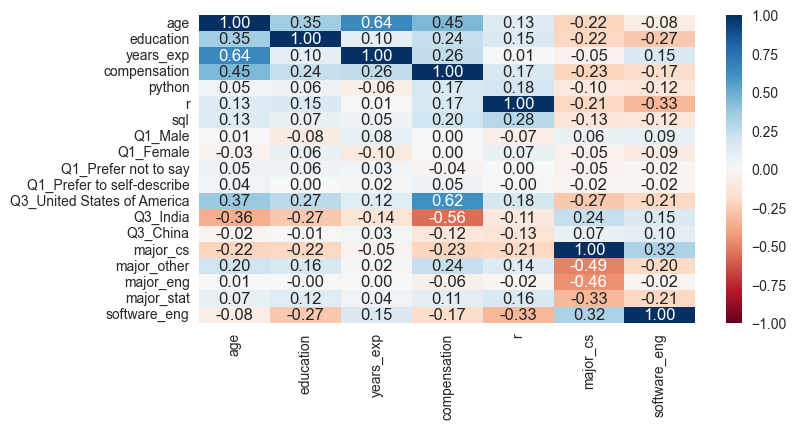

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(X_train       
            .assign(software_eng=y_train)
            .corr(method='spearman')
            .loc[:, ['age','education', 'years_exp', 'compensation', 'r', 
                     'major_cs', 'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)


- 그런데 신기하게도 years_exp, education의 상관도는 0.1이다.  
- 트리 모델이 분리할 수 있는 비선형 관계가 있을 수 있다.  

스캐터 플롯으로 확인해보자.

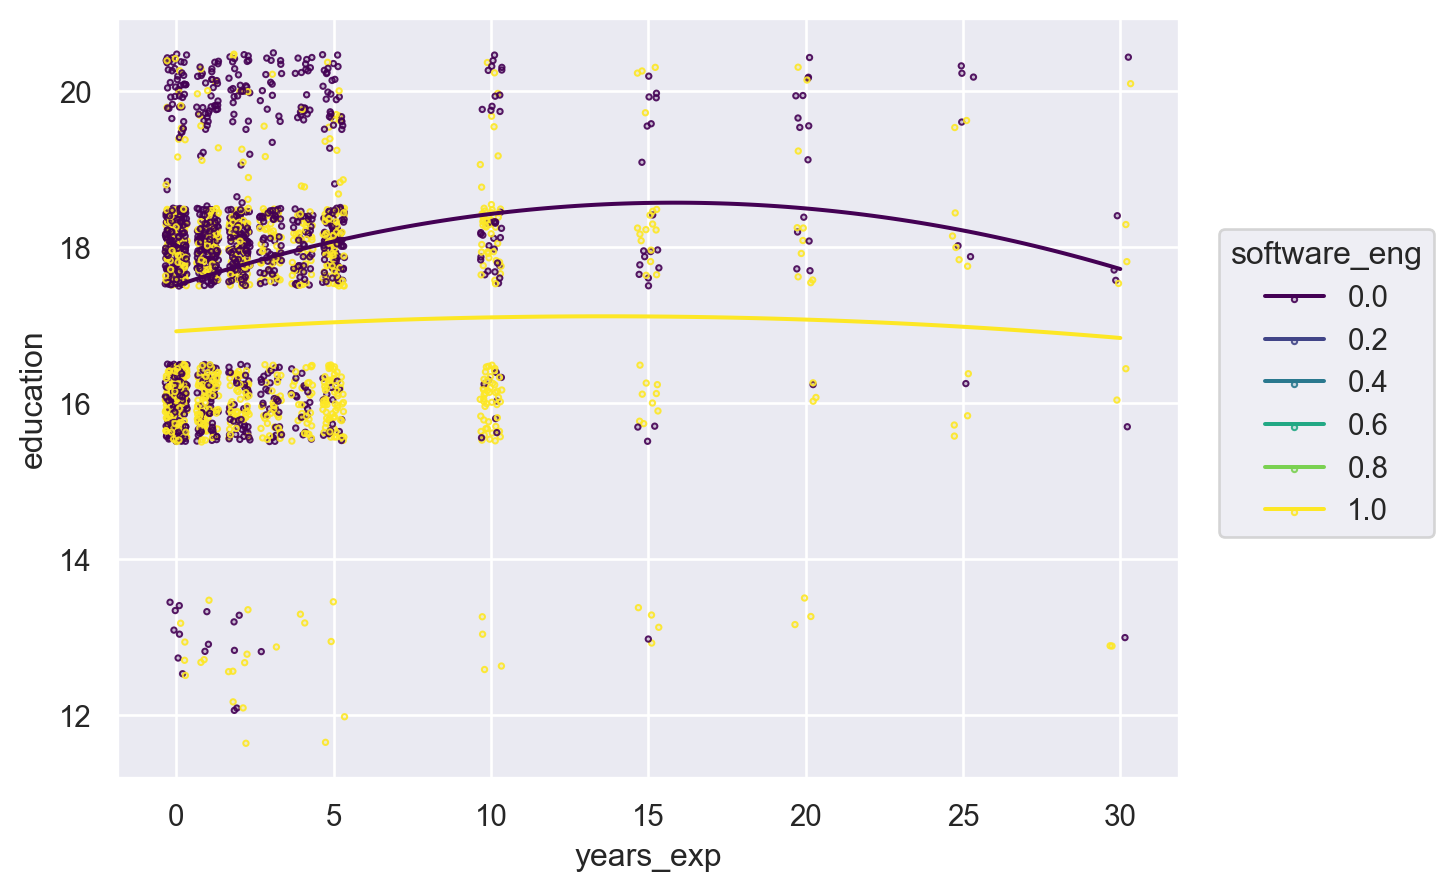

<Figure size 800x400 with 0 Axes>

In [16]:
import seaborn.objects as so
fig = plt.figure(figsize=(8, 4))
(so
.Plot(X_train.assign(software_eng=y_train), x='years_exp', y='education',
color='software_eng')
.add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
.add(so.Line(), so.PolyFit())
.scale(color='viridis')
#.on(fig) # not required unless saving to image
.plot() # ditto
)

- 소프트웨어엔지니어의 교육수준이 데이터과학자보다 낮은 것으로 확인된다.

이제 major_cs와 R 및 대상 레이블 간의 관계를 살펴보겠습니다. 

여기에는 3가지의 범주형 데이터가 있습니다. 이를 정량화하기 위해 Pandas 그룹화 또는 pd.crosstab을 사용하여 이를 정량화할 수 있습니다:

In [17]:
print(X_train
      .assign(software_eng=y_train)
      .groupby(['software_eng', 'r', 'major_cs'])
      .age
      .count()
      .unstack()
      .unstack()
      )

major_cs        0         1     
r               0    1    0    1
software_eng                    
0             410  390  243  110
1             308   53  523   73


- R을 사용하지 않으면 소프트웨어 엔지니어일 확률이 높음을 나타낸다.

크로스탭 버전으로도 구현해보자.

In [18]:
both = (X_train
        .assign(software_eng=y_train)
        )

print(pd.crosstab(index=both.software_eng, columns=[both.major_cs, both.r]))

major_cs        0         1     
r               0    1    0    1
software_eng                    
0             410  390  243  110
1             308   53  523   73
